# Tempo de processamento em função do tamanho do janelamento

Nesse Jupyter, vamos testar o tempo que a Raspberry leva para aplicar o DaS e extrair as features em função do tamanho do janelamento. O tempo de classificação não é alterado pelo tamanho do janelamento já que o tamanho do vetor de features possui valor fixo para qualquer tamanho de janela.

Como o librosa não preserva a profundidade de bits de um áudio, eu vou usar o próprio ReSpeaker para gravar algumas janelas nesse Jupyter. Assim, eu garanto que todo o processamento vai ser feito em cima de amostras INT16. Caso eu usasse arquivos WAVs prontos, correria o risco de não obter o resultado verdadeiro, pois o librosa transformaria tudo em FLOAT32.

In [1]:
import sys
import time
import os
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

sys.path.append("/home/pi/Programming/IC2019/Raspberry/Python/")
sys.path.append("/home/pi/Programming/IC2019/DOA/Python/")

from SimularArrayMicrofonesClass import SimularArrayMicrofones
from delayAndSum import delayAndSum as DaS
from extracaoFeatures import extrairFeaturesUnicoFrame as ExtrairFeatures
from iniciarNormalizadorEClassificador import main as IniciarObjetos

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [11, 5.5], 
          'axes.labelsize': 12,
          'axes.titlesize':12, 
          'font.size': 11,
          'legend.fontsize': 11, 
          'xtick.labelsize': 10, 
          'ytick.labelsize': 10
         }
plt.rcParams.update(params)

## Definição de funções

In [3]:
def gravarJanela(tempoJanela=0.200, respeakerIndex=0, respeakerFreqAmostragem=16000, respeakerProfundidade=2, respeakerCanais=4):

    # DEFININDO O TAMANHO DA JANELA EM AMOSTRAS
    tamanhoJanela = int(tempoJanela * respeakerFreqAmostragem)

    # INSTANCIANDO UM OBJ PY AUDIO E MANDANDO OS PARAMETROS INICIAIS
    objPyAudio = pyaudio.PyAudio()
    stream = objPyAudio.open(
        input_device_index = respeakerIndex,
        rate               = respeakerFreqAmostragem,
        format             = objPyAudio.get_format_from_width(respeakerProfundidade),
        channels           = respeakerCanais,
        input              = True    
    )

    # GRAVANDO A JANELA
    janelaBinaria = stream.read(tamanhoJanela)

    # MATANDO OS OBJETOS PRA LIMPAR MEMORIA
    stream.stop_stream()
    stream.close()
    objPyAudio.terminate()
        
    # CONVERTO A JANELA PRA INT 16
    janelaInt16 = np.fromstring(janelaBinaria, dtype=np.int16)
    
    # COMO TEM OS 4 MICS NA JANELA, VOU DAR UM RESHAPE PRA CADA MIC FICAR EM UMA LINHA
    janelaInt16 = janelaInt16.reshape((tamanhoJanela, respeakerCanais)).T
    
    # GARANINDO QUE A DIMENSIONALIDADE ESTA CORRETA
    assert janelaInt16.shape[0] == respeakerCanais and janelaInt16.shape[1] == tamanhoJanela, "Erro na dimensionalidade da janela gravada!"
    
    return janelaInt16

Testando a função:

In [4]:
janela = gravarJanela(tempoJanela=5)
Audio(data=janela[2], rate=16000)

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


## Iniciando os objetos objClassificador e objNormalizador

In [5]:
caminhoCSV = "/home/pi/Datasets/SESA_v2_16kHz_16bits_200ms_58features_desescalonado_remocaoSilencio.csv"
objClassificador, objNormalizador = IniciarObjetos(caminhoCSV, classificador=None, verbose=True)

Carregando o CSV do dataset
CSV carregado
Separando o que é data e target
Iniciando objeto normalizador
Treinando objeto normalizador
Normalizando os dados de treinamento
Instanciando objeto classificador
Treinando o classificador
objClassificador e objNormalizador prontos: operação finalizada.


## Fazendo uma rodada com 200 ms

In [6]:
# GRAVANDO A JANELA
janela = gravarJanela(tempoJanela=0.200)

# APLICANDO O DAS
tempoInicio = time.time()
sinalDaS    = DaS(janela)
tempoDaS    = time.time() - tempoInicio

# EXTRAINDO AS FEATURES
tempoInicio   = time.time()
features, dictTempoExtracaoCadaFeature = ExtrairFeatures(sinalDaS, freqAmostragem=16000)
tempoExtracao = time.time() - tempoInicio

# NORMALIZANDO AS FEATURES
tempoInicio       = time.time()
features          = objNormalizador.transform([features])[0]
tempoNormalizacao = time.time() - tempoInicio

# PREDIZENDO
tempoInicio        = time.time()
predicao           = objClassificador.predict([features])[0]
tempoClassificacao = time.time() - tempoInicio

# TEMPO TOTAL
tempoTotal = tempoDaS + tempoExtracao + tempoNormalizacao + tempoClassificacao

print("Shape da janela:", janela.shape)
print("Shape após DaS:", sinalDaS.shape)
print("Shape do vetor de features:", features.shape)
print("Tempo do DaS:          ", tempoDaS)
print("Tempo da extração:     ", tempoExtracao)
print("Tempo da normalização: ", tempoNormalizacao)
print("Tempo da classificação:", tempoClassificacao)
print("Tempo total:           ", tempoTotal)

Shape da janela: (4, 3200)
Shape após DaS: (3160,)
Shape do vetor de features: (58,)
Tempo do DaS:           0.014553070068359375
Tempo da extração:      0.12193846702575684
Tempo da normalização:  0.0013706684112548828
Tempo da classificação: 0.0013971328735351562
Tempo total:            0.13925933837890625


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [7]:
tempoTotal = 0
for chaveAtual in dictTempoExtracaoCadaFeature:
    print(chaveAtual + ":", dictTempoExtracaoCadaFeature[chaveAtual])
    tempoTotal += dictTempoExtracaoCadaFeature[chaveAtual]
    
print("\nTempo total com a soma das individuais:", tempoTotal)
print("Tempo total medido:", tempoExtracao)

RMS: 0.0013899803161621094
Centroide: 0.005222797393798828
LarguraBanda: 0.006105899810791016
Planicidade: 0.00459742546081543
Rolloff: 0.004755973815917969
ZCR: 0.0018453598022460938
20MFCCs: 0.0458834171295166
20MelEspectrogramas: 0.013772249221801758
12Cromagramas: 0.037450313568115234

Tempo total com a soma das individuais: 0.12102341651916504
Tempo total medido: 0.12193846702575684


## Testando com diferentes janelamentos

In [8]:
# DEFININDO OS JANELAMENTOS QUE SERAO TESTADOS
janelamentos   = np.arange(0.025, 3.001, 0.025)
repetibilidade = 10

# MATRIZES QUE VAO GUARDAR OS TEMPOS. CADA LINHA UM JANELAMENTO CADA COLUNA UM REPETICAO
matrizTemposDaS           = []
matrizTemposExtracao      = []
matrizTemposNormalizacao  = []
matrizTemposClassificacao = []
matrizTemposTotal         = []
matrizTemposRMS           = []
matrizTemposCentroide     = []
matrizTemposLarguraBanda  = []
matrizTemposPlanicidade   = []
matrizTemposRolloff       = []
matrizTemposZCR           = []
matrizTemposMFCC          = []
matrizTemposMelEspectro   = []
matrizTemposCromagrama    = []

# TESTANDO COM CADA JANELAMENTO
for tempoJanelaAtual in janelamentos:

    # ARRAYS QUE VAO GUARDAR OS TEMPOS DO JANELAMENTO ATUAL
    arrayTemposDaSJanelamentoAtual           = []
    arrayTemposExtracaoJanelamentoAtual      = []
    arrayTemposNormalizacaoJanelamentoAtual  = []
    arrayTemposClassificacaoJanelamentoAtual = []
    arrayTemposTotalJanelamentoAtual         = []
    arrayTemposRMSJanelamentoAtual           = []
    arrayTemposCentroideJanelamentoAtual     = []
    arrayTemposLarguraBandaJanelamentoAtual  = []
    arrayTemposPlanicidadeJanelamentoAtual   = []
    arrayTemposRolloffJanelamentoAtual       = []
    arrayTemposZCRJanelamentoAtual           = []
    arrayTemposMFCCJanelamentoAtual          = []
    arrayTemposMelEspectroJanelamentoAtual   = []
    arrayTemposCromagramaJanelamentoAtual    = []
    
    # GRAVANDO A JANELA
    print("Iniciando medição com janelamento de", tempoJanelaAtual, "segundos")
    janela = gravarJanela(tempoJanela=tempoJanelaAtual)

    # GARANTINDO REPETIBILIDADE NO EXPERIMENTO
    for i in range(repetibilidade):
        
        # APLICANDO O DAS
        tempoInicio = time.time()
        sinalDaS    = DaS(janela)
        tempoDaS    = time.time() - tempoInicio

        # EXTRAINDO AS FEATURES
        tempoInicio   = time.time()
        features, dictTempoExtracaoCadaFeature = ExtrairFeatures(sinalDaS, freqAmostragem=16000)
        tempoExtracao = time.time() - tempoInicio
        
        # NORMALIZANDO AS FEATURES
        tempoInicio       = time.time()
        features          = objNormalizador.transform([features])[0]
        tempoNormalizacao = time.time() - tempoInicio

        # PREDIZENDO
        tempoInicio        = time.time()
        predicao           = objClassificador.predict([features])[0]
        tempoClassificacao = time.time() - tempoInicio

        # TEMPO TOTAL
        tempoTotal = tempoDaS + tempoExtracao + tempoNormalizacao + tempoClassificacao
        
        # SALVANDO OS TEMPOS DO JANELAMENTO ATUAL
        arrayTemposDaSJanelamentoAtual.append(tempoDaS)
        arrayTemposExtracaoJanelamentoAtual.append(tempoExtracao)
        arrayTemposNormalizacaoJanelamentoAtual.append(tempoNormalizacao)
        arrayTemposClassificacaoJanelamentoAtual.append(tempoClassificacao)
        arrayTemposTotalJanelamentoAtual.append(tempoTotal)
        arrayTemposRMSJanelamentoAtual.append(dictTempoExtracaoCadaFeature["RMS"])
        arrayTemposCentroideJanelamentoAtual.append(dictTempoExtracaoCadaFeature["Centroide"])
        arrayTemposLarguraBandaJanelamentoAtual.append(dictTempoExtracaoCadaFeature["LarguraBanda"])
        arrayTemposPlanicidadeJanelamentoAtual.append(dictTempoExtracaoCadaFeature["Planicidade"])
        arrayTemposRolloffJanelamentoAtual.append(dictTempoExtracaoCadaFeature["Rolloff"])
        arrayTemposZCRJanelamentoAtual.append(dictTempoExtracaoCadaFeature["ZCR"])
        arrayTemposMFCCJanelamentoAtual.append(dictTempoExtracaoCadaFeature["20MFCCs"])
        arrayTemposMelEspectroJanelamentoAtual.append(dictTempoExtracaoCadaFeature["20MelEspectrogramas"])
        arrayTemposCromagramaJanelamentoAtual.append(dictTempoExtracaoCadaFeature["12Cromagramas"])
        
    # GUARDANDO AS LINAS NAS MATRIZES
    matrizTemposDaS.append(arrayTemposDaSJanelamentoAtual)
    matrizTemposExtracao.append(arrayTemposExtracaoJanelamentoAtual)
    matrizTemposNormalizacao.append(arrayTemposNormalizacaoJanelamentoAtual)
    matrizTemposClassificacao.append(arrayTemposClassificacaoJanelamentoAtual)
    matrizTemposTotal.append(arrayTemposTotalJanelamentoAtual)
    matrizTemposRMS.append(arrayTemposRMSJanelamentoAtual)
    matrizTemposCentroide.append(arrayTemposCentroideJanelamentoAtual)
    matrizTemposLarguraBanda.append(arrayTemposLarguraBandaJanelamentoAtual)
    matrizTemposPlanicidade.append(arrayTemposPlanicidadeJanelamentoAtual)
    matrizTemposRolloff.append(arrayTemposRolloffJanelamentoAtual)
    matrizTemposZCR.append(arrayTemposZCRJanelamentoAtual)
    matrizTemposMFCC.append(arrayTemposMFCCJanelamentoAtual)
    matrizTemposMelEspectro.append(arrayTemposMelEspectroJanelamentoAtual)
    matrizTemposCromagrama.append(arrayTemposCromagramaJanelamentoAtual)

Iniciando medição com janelamento de 0.025 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.05 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.07500000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.1 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.125 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.15 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.17500000000000002 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.2 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.225 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.25 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.275 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.30000000000000004 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.32500000000000007 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.35000000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.37500000000000006 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.4 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.42500000000000004 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.45000000000000007 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.47500000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.5 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.525 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.55 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.5750000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.6000000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.6250000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.65 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.675 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.7000000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.7250000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.7500000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.775 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.8 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.8250000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.8500000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.8750000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.9 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.925 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.9500000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 0.9750000000000001 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.0 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.025 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.05 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.075 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.0999999999999999 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.125 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.15 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.175 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.2 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.225 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.25 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.275 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.3 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.325 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.35 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.375 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.4 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.425 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.45 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.475 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.5 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.525 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.55 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.575 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.6 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.625 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.65 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.675 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.7 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.725 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.75 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.775 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.8 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.825 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.85 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.875 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.9 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.925 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.95 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 1.975 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.0 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.025 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.05 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.075 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.1 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.125 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.15 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.175 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.2 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.225 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.25 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.275 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.3 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.325 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.35 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.375 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.4 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.4250000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.45 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.475 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.5 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.525 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.5500000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.575 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.6 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.625 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.65 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Iniciando medição com janelamento de 2.6750000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Iniciando medição com janelamento de 2.7 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Iniciando medição com janelamento de 2.725 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.75 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.775 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.8000000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Iniciando medição com janelamento de 2.825 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.85 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Iniciando medição com janelamento de 2.875 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.9 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.9250000000000003 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.95 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 2.975 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

Iniciando medição com janelamento de 3.0 segundos


/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/l

## SALVANDO E VISUALIZANDO

A célula abaixo tira a média e o desvio de cada item para cada janelamento. Depois disso, as outras células salvam e printam os resultados.

In [9]:
dispositivo   = "Raspberry"
caminhoSalvar = "/home/pi/Programming/IC2019/Raspberry/Resultados/"

# CRIANDO OS ARRAYS DE TEMPO MEDIO E DESVIO PADRAO
# DaS
arrayTempoMedioDaSCadaJanelamento             = []
arrayDesvioPadraoDaSCadaJanelamento           = []
# Extracao
arrayTempoMedioExtracaoCadaJanelamento        = []
arrayDesvioPadraoExtracaoCadaJanelamento      = []
# Normalizacao
arrayTempoMedioNormalizacaoCadaJanelamento    = []
arrayDesvioPadraoNormalizacaoCadaJanelamento  = []
# Classificacao
arrayTempoMedioClassificacaoCadaJanelamento   = []
arrayDesvioPadraoClassificacaoCadaJanelamento = []
# Total
arrayTempoMedioTotalCadaJanelamento           = []
arrayDesvioPadraoTotalCadaJanelamento         = []
# RMS
arrayTempoMedioRMSCadaJanelamento             = []
arrayDesvioPadraoRMSCadaJanelamento           = []
# Centroide
arrayTempoMedioCentroideCadaJanelamento       = []
arrayDesvioPadraoCentroideCadaJanelamento     = []
# Largura de Banda
arrayTempoMedioLarguraBandaCadaJanelamento    = []
arrayDesvioPadraoLarguraBandaCadaJanelamento  = []
# Planicidade
arrayTempoMedioPlanicidadeCadaJanelamento     = []
arrayDesvioPadraoPlanicidadeCadaJanelamento   = []
# Rolloff
arrayTempoMedioRolloffCadaJanelamento         = []
arrayDesvioPadraoRolloffCadaJanelamento       = []
# ZCR
arrayTempoMedioZCRCadaJanelamento             = []
arrayDesvioPadraoZCRCadaJanelamento           = []
# MFCC
arrayTempoMedioMFCCCadaJanelamento            = []
arrayDesvioPadraoMFCCCadaJanelamento          = []
# Mel Espectrograma
arrayTempoMedioMelEspectroCadaJanelamento     = []
arrayDesvioPadraoMelEspectroCadaJanelamento   = []
# Cromagrama
arrayTempoMedioCromagramaCadaJanelamento      = []
arrayDesvioPadraoCromagramaCadaJanelamento    = []

# CASO A CELULA ACIMA TENHA SIDO INTERROMPIDA, VOU PRECISAR CORRIGIR O TAMANHODOARRAY DE JANELAMENTOS
janelamentos = janelamentos[:len(matrizTemposTotal)]

for i in range(len(janelamentos)):
    # DaS
    arrayTempoMedioDaSCadaJanelamento.append(np.mean(matrizTemposDaS[i]))
    arrayDesvioPadraoDaSCadaJanelamento.append(np.std(matrizTemposDaS[i]))
    # Extracao
    arrayTempoMedioExtracaoCadaJanelamento.append(np.mean(matrizTemposExtracao[i]))
    arrayDesvioPadraoExtracaoCadaJanelamento.append(np.std(matrizTemposExtracao[i]))
    # Normalizacao
    arrayTempoMedioNormalizacaoCadaJanelamento.append(np.mean(matrizTemposNormalizacao[i]))
    arrayDesvioPadraoNormalizacaoCadaJanelamento.append(np.std(matrizTemposNormalizacao[i]))
    # Classificacao
    arrayTempoMedioClassificacaoCadaJanelamento.append(np.mean(matrizTemposClassificacao[i]))
    arrayDesvioPadraoClassificacaoCadaJanelamento.append(np.std(matrizTemposClassificacao[i]))
    # Total
    arrayTempoMedioTotalCadaJanelamento.append(np.mean(matrizTemposTotal[i]))
    arrayDesvioPadraoTotalCadaJanelamento.append(np.std(matrizTemposTotal[i]))
    # RMS
    arrayTempoMedioRMSCadaJanelamento.append(np.mean(matrizTemposRMS[i]))
    arrayDesvioPadraoRMSCadaJanelamento.append(np.std(matrizTemposRMS[i]))
    # Centroide
    arrayTempoMedioCentroideCadaJanelamento.append(np.mean(matrizTemposCentroide[i]))
    arrayDesvioPadraoCentroideCadaJanelamento.append(np.std(matrizTemposCentroide[i]))
    # Largura de Banda
    arrayTempoMedioLarguraBandaCadaJanelamento.append(np.mean(matrizTemposLarguraBanda[i]))
    arrayDesvioPadraoLarguraBandaCadaJanelamento.append(np.std(matrizTemposLarguraBanda[i]))
    # Planicidade
    arrayTempoMedioPlanicidadeCadaJanelamento.append(np.mean(matrizTemposPlanicidade[i]))
    arrayDesvioPadraoPlanicidadeCadaJanelamento.append(np.std(matrizTemposPlanicidade[i]))
    # Rolloff
    arrayTempoMedioRolloffCadaJanelamento.append(np.mean(matrizTemposRolloff[i]))
    arrayDesvioPadraoRolloffCadaJanelamento.append(np.std(matrizTemposRolloff[i]))
    # ZCR
    arrayTempoMedioZCRCadaJanelamento.append(np.mean(matrizTemposZCR[i]))
    arrayDesvioPadraoZCRCadaJanelamento.append(np.std(matrizTemposZCR[i]))
    # MFCC
    arrayTempoMedioMFCCCadaJanelamento.append(np.mean(matrizTemposMFCC[i]))
    arrayDesvioPadraoMFCCCadaJanelamento.append(np.std(matrizTemposMFCC[i]))
    # Mel Espectrograma
    arrayTempoMedioMelEspectroCadaJanelamento.append(np.mean(matrizTemposMelEspectro[i]))
    arrayDesvioPadraoMelEspectroCadaJanelamento.append(np.std(matrizTemposMelEspectro[i]))
    # Cromagrama
    arrayTempoMedioCromagramaCadaJanelamento.append(np.mean(matrizTemposCromagrama[i]))
    arrayDesvioPadraoCromagramaCadaJanelamento.append(np.std(matrizTemposCromagrama[i]))

### Salvando

In [10]:
# ABRINDO O ARQUIVO TXT
objFile = open(caminhoSalvar+"tempoProcessamentoXtamanhoJanelamento_"+dispositivo+".txt", "a")

# ESCREVENDO O CABECALHO
objFile.write("EXPERIMENTO RODADO EM:" + str(time.time()) + "\n")
objFile.write("DISPOSITIVO:" + dispositivo + "\n")
objFile.write("REPETIBILIDADE:" + str(repetibilidade) + "\n")

# ESCREVENDO O RESULTADO DE CADA ARRAY
# Janelamentos
objFile.write("janelamentos: [")
for valorAtual in janelamentos:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# DaS
objFile.write("arrayTempoMedioDaSCadaJanelamento: [")
for valorAtual in arrayTempoMedioDaSCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoDaSCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoDaSCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Extracao
objFile.write("arrayTempoMedioExtracaoCadaJanelamento: [")
for valorAtual in arrayTempoMedioExtracaoCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoExtracaoCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoExtracaoCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Normalizacao
objFile.write("arrayTempoMedioNormalizacaoCadaJanelamento: [")
for valorAtual in arrayTempoMedioNormalizacaoCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoNormalizacaoCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoNormalizacaoCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Classificacao
objFile.write("arrayTempoMedioClassificacaoCadaJanelamento: [")
for valorAtual in arrayTempoMedioClassificacaoCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoClassificacaoCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoClassificacaoCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Total
objFile.write("arrayTempoMedioTotalCadaJanelamento: [")
for valorAtual in arrayTempoMedioTotalCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoTotalCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoTotalCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# RMS
objFile.write("arrayTempoMedioRMSCadaJanelamento: [")
for valorAtual in arrayTempoMedioRMSCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoRMSCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoRMSCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Centroide
objFile.write("arrayTempoMedioCentroideCadaJanelamento: [")
for valorAtual in arrayTempoMedioCentroideCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoCentroideCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoCentroideCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Largura de Banda
objFile.write("arrayTempoMedioLarguraBandaCadaJanelamento: [")
for valorAtual in arrayTempoMedioLarguraBandaCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoLarguraBandaCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoLarguraBandaCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Planicidade
objFile.write("arrayTempoMedioPlanicidadeCadaJanelamento: [")
for valorAtual in arrayTempoMedioPlanicidadeCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoPlanicidadeCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoPlanicidadeCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Rolloff
objFile.write("arrayTempoMedioRolloffCadaJanelamento: [")
for valorAtual in arrayTempoMedioRolloffCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoRolloffCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoRolloffCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# ZCR
objFile.write("arrayTempoMedioZCRCadaJanelamento: [")
for valorAtual in arrayTempoMedioZCRCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoZCRCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoZCRCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# MFCC
objFile.write("arrayTempoMedioMFCCCadaJanelamento: [")
for valorAtual in arrayTempoMedioMFCCCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoMFCCCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoMFCCCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Mel Espectrograma
objFile.write("arrayTempoMedioMelEspectroCadaJanelamento: [")
for valorAtual in arrayTempoMedioMelEspectroCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoMelEspectroCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoMelEspectroCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")

# Cromagrama
objFile.write("arrayTempoMedioCromagramaCadaJanelamento: [")
for valorAtual in arrayTempoMedioCromagramaCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n")
objFile.write("arrayDesvioPadraoCromagramaCadaJanelamento: [")
for valorAtual in arrayDesvioPadraoCromagramaCadaJanelamento:
    objFile.write(str(valorAtual) + ", ")
objFile.write("]\n\n\n")

# FECHANDO
objFile.close()  

### Visualizando

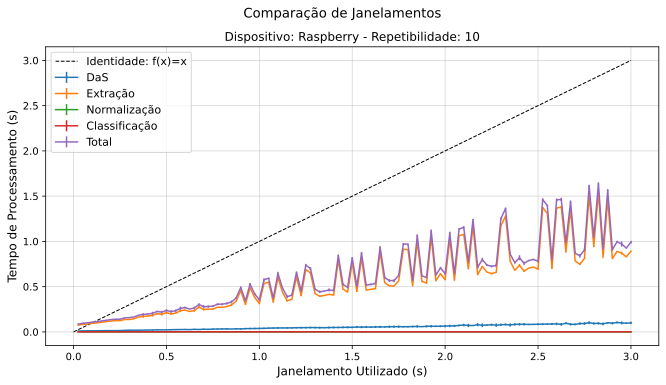

In [11]:
# PRINTANDO
plt.plot([0, janelamentos[-1]], [0, janelamentos[-1]], "--", linewidth=1, color="black", label="Identidade: f(x)=x")
plt.errorbar(janelamentos, arrayTempoMedioDaSCadaJanelamento, yerr=arrayDesvioPadraoDaSCadaJanelamento, fmt="-", label="DaS")
plt.errorbar(janelamentos, arrayTempoMedioExtracaoCadaJanelamento, yerr=arrayDesvioPadraoExtracaoCadaJanelamento, fmt="-", label="Extração")
plt.errorbar(janelamentos, arrayTempoMedioNormalizacaoCadaJanelamento, yerr=arrayDesvioPadraoNormalizacaoCadaJanelamento, fmt="-", label="Normalização")
plt.errorbar(janelamentos, arrayTempoMedioClassificacaoCadaJanelamento, yerr=arrayDesvioPadraoClassificacaoCadaJanelamento, fmt="-", label="Classificação")
plt.errorbar(janelamentos, arrayTempoMedioTotalCadaJanelamento, yerr=arrayDesvioPadraoTotalCadaJanelamento, fmt="-", label="Total")
plt.xlabel("Janelamento Utilizado (s)")
plt.ylabel("Tempo de Processamento (s)")
plt.suptitle("Comparação de Janelamentos")
plt.title("Dispositivo: " + dispositivo + " - Repetibilidade: " + str(repetibilidade))
#plt.yticks(np.concatenate(([0], janelamentos)))
#plt.xticks(np.concatenate(([0], janelamentos)), rotation=45)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(caminhoSalvar+"comparacaoJanelamentos"+dispositivo+".pdf", format='pdf', bbox_inches='tight')
plt.show()

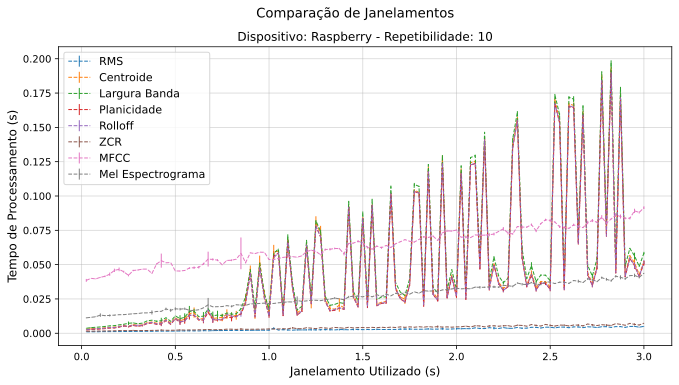

In [16]:
grossura = 1
plt.errorbar(janelamentos, arrayTempoMedioRMSCadaJanelamento, yerr=arrayDesvioPadraoRMSCadaJanelamento, fmt="--", linewidth=grossura, label="RMS")
plt.errorbar(janelamentos, arrayTempoMedioCentroideCadaJanelamento, yerr=arrayDesvioPadraoCentroideCadaJanelamento, fmt="--", linewidth=grossura, label="Centroide")
plt.errorbar(janelamentos, arrayTempoMedioLarguraBandaCadaJanelamento, yerr=arrayDesvioPadraoLarguraBandaCadaJanelamento, fmt="--", linewidth=grossura, label="Largura Banda")
plt.errorbar(janelamentos, arrayTempoMedioPlanicidadeCadaJanelamento, yerr=arrayDesvioPadraoPlanicidadeCadaJanelamento, fmt="--", linewidth=grossura, label="Planicidade")
plt.errorbar(janelamentos, arrayTempoMedioRolloffCadaJanelamento, yerr=arrayDesvioPadraoRolloffCadaJanelamento, fmt="--", linewidth=grossura, label="Rolloff")
plt.errorbar(janelamentos, arrayTempoMedioZCRCadaJanelamento, yerr=arrayDesvioPadraoZCRCadaJanelamento, fmt="--", linewidth=grossura, label="ZCR")
plt.errorbar(janelamentos, arrayTempoMedioMFCCCadaJanelamento, yerr=arrayDesvioPadraoMFCCCadaJanelamento, fmt="--", linewidth=grossura, label="MFCC")
plt.errorbar(janelamentos, arrayTempoMedioMelEspectroCadaJanelamento, yerr=arrayDesvioPadraoMelEspectroCadaJanelamento, fmt="--", linewidth=grossura, label="Mel Espectrograma")
plt.xlabel("Janelamento Utilizado (s)")
plt.ylabel("Tempo de Processamento (s)")
plt.suptitle("Comparação de Janelamentos")
plt.title("Dispositivo: " + dispositivo + " - Repetibilidade: " + str(repetibilidade))
#plt.yticks(np.concatenate(([0], janelamentos)))
#plt.xticks(np.concatenate(([0], janelamentos)), rotation=45)
plt.grid(alpha=0.5)
plt.legend()
plt.savefig(caminhoSalvar+"comparacaoJanelamentos"+dispositivo+"_featuresIndividualmente.pdf", format='pdf', bbox_inches='tight')
plt.show()